## Import and Clean Data

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


In [23]:
raw_data = pd.read_csv("../data/Salary.csv")
education_levels = ["high school", "bachelor degree", "masters degree", "phd"]
raw_data

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000.0,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000.0,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000.0,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000.0,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000.0,USA,Asian,0
...,...,...,...,...,...,...,...,...,...
6679,49.0,Female,3,Director of Marketing,20.0,200000.0,UK,Mixed,0
6680,32.0,Male,0,Sales Associate,3.0,50000.0,Australia,Australian,0
6681,30.0,Female,1,Financial Manager,4.0,55000.0,China,Chinese,0
6682,46.0,Male,2,Marketing Manager,14.0,140000.0,China,Korean,0


In [24]:
df = raw_data[["Job Title","Education Level","Years of Experience","Country","Salary"]]
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [25]:
isomapping = {"usa":"us", "china":"cn","australia":"au","uk":"uk","canada":"ca"}
df['country'] = df['country'].str.lower().map(isomapping)

C:\Users\nnsar\AppData\Local\Temp\ipykernel_18712\1632140083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country'] = df['country'].str.lower().map(isomapping)


In [26]:
df['job_title']=df['job_title'].str.lower()

C:\Users\nnsar\AppData\Local\Temp\ipykernel_18712\1849090496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job_title']=df['job_title'].str.lower()


In [27]:
df['education_level']

0       1
1       2
2       3
3       1
4       2
       ..
6679    3
6680    0
6681    1
6682    2
6683    0
Name: education_level, Length: 6684, dtype: int64

In [28]:
sampled_df = df.sample(n=len(df), replace=True, random_state=100)


## Setting up Lin Reg Model with word embeddings

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [30]:
features = ["job_title","education_level", "years_of_experience", "country"]

In [31]:
X = sampled_df[features]
y = sampled_df['salary']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
def evaluate_regression_metrics(y_true, y_pred):
    """
    Evaluate regression metrics: Mean Absolute Error, Mean Squared Error, and R-squared.

    Parameters:
    y_true (array-like): Actual target values.
    y_pred (array-like): Predicted target values.

    Returns:
    dict: A dictionary containing MAE, MSE, and R-squared.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'R-squared': r2
    }

In [34]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Step 1: Replace rare job titles with 'other'
def filter_infrequent_titles(df, col='job_title', min_freq=10):
    value_counts = df[col].value_counts()
    common_titles = value_counts[value_counts >= min_freq].index
    df = df.copy()
    df[col] = df[col].apply(lambda x: x if x in common_titles else 'other')
    return df

# Apply it to X 
X_filtered = filter_infrequent_titles(X, col='job_title', min_freq=10)

# Step 2: Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('job_title', OneHotEncoder(handle_unknown='ignore'), ['job_title']),
        ('years_of_experience', StandardScaler(), ['years_of_experience']),
        ('country', OneHotEncoder(handle_unknown='ignore'), ['country'])
    ]
)

# Step 3: Build pipeline with RandomForestRegressor
word_processing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])


# Step 4: Fit the model
word_processing_pipeline.fit(X_filtered, y)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('job_title', ...), ('years_of_experience', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor inside the pipeline
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Wrap pipeline in GridSearchCV
grid_search = GridSearchCV(
    word_processing_pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  
    n_jobs=-1,     
    verbose=2
)

# Fit the model
grid_search.fit(X_filtered, y)

# Best model and parameters
print("Best R² score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best R² score: 0.9268269168350161
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [36]:
evaluate_regression_metrics(word_processing_pipeline.predict(X_test), y_test)

{'Mean Absolute Error': 6617.375918440123,
 'Mean Squared Error': 150006090.96142158,
 'R-squared': 0.9418994155241106}

In [37]:
y_pred = word_processing_pipeline.predict(X_test)

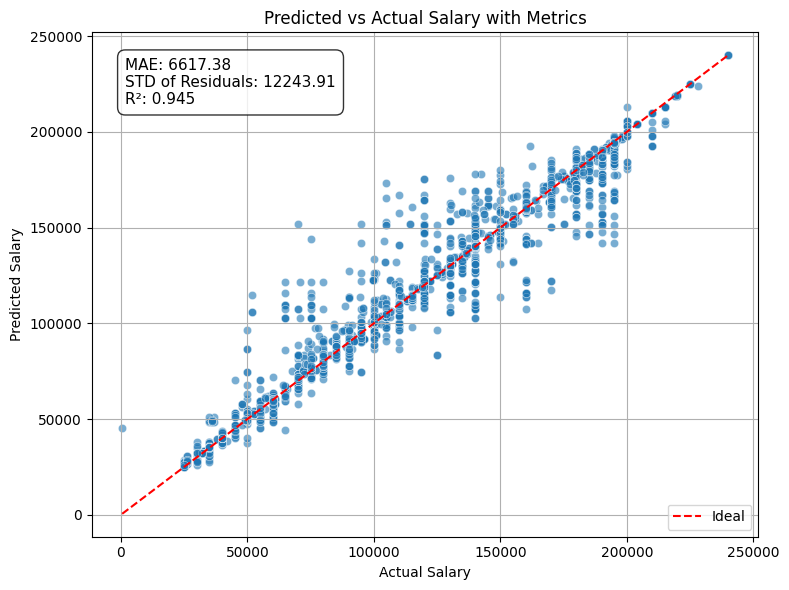

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
residuals = y_test - y_pred
residual_std = np.std(residuals)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')

# Add metrics text box
textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'STD of Residuals: {residual_std:.2f}',
    f'R²: {r2:.3f}',
))

props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

# Labels and title
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary with Metrics')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Exporting the Model

In [39]:
import pickle as pkl

In [40]:
filepath = "../models/rfr_model.pkl"
with open(filepath, "wb") as f:
    pkl.dump(word_processing_pipeline, f)